In [2]:
!nvidia-smi

Sun Feb  5 23:08:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [4]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Change rootpath to VGGNet

ROOT_PATH = '/content/drive/MyDrive/VGGNet'

In [7]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'/content/drive/MyDrive/VGGNet'

In [8]:
# re-size all the images to 224 , 224 size
IMAGE_SIZE = [224, 224]

train_path = 'Flowers/train'
valid_path = 'Flowers/validation'

In [9]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG, Here we will be using imagenet weights
# With include_top = False,  it will drop ANN/FC layers and only copy Convulational layer
# Also we will be adding 3 to the input_shape as it is RGB channel so input size would be 224*224*3

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [10]:
# To check the  what all layers got copied from the Imagenet
for layer in vgg16.layers:
    print(layer)

In [11]:
# We are making Convulational layer to non-trainable
for layer in vgg16.layers:
    layer.trainable = False

In [12]:
vgg16

In [13]:
# To check what all layers are trainables

for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [14]:
# Printing summary of VGG16
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
# useful for getting number of output classes
folders = glob('Flowers/train/*')

In [27]:
folders

['Flowers/train/daisy',
 'Flowers/train/tulip',
 'Flowers/train/dandelion',
 'Flowers/train/rose',
 'Flowers/train/sunflower']

In [28]:
len(folders)

5

In [29]:
# Creating a sequential model and adding VGG16, flattening model

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [30]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21,138,757
Trainable params: 6,424,069
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
# Compile the model with below mentioned loss/cost and optimization method to use

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [34]:
# Use the Image Data Generator to import the images from the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [36]:
test_datagen

In [38]:
# Make sure we provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Flowers/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 600 images belonging to 5 classes.


In [39]:
# Preparing Test dataset

test_set = test_datagen.flow_from_directory('Flowers/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 300 images belonging to 5 classes.


In [40]:
# fit the model
# Run the cell. It will take some time to execute

r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
19/19 [==============================] - 406s 22s/step - loss: 3.4316 - accuracy: 0.3650 - val_loss: 1.0047 - val_accuracy: 0.6200
Epoch 2/10
19/19 [==============================] - 12s 613ms/step - loss: 0.6823 - accuracy: 0.7500 - val_loss: 1.0054 - val_accuracy: 0.7033
Epoch 3/10
19/19 [==============================] - 11s 566ms/step - loss: 0.4798 - accuracy: 0.8400 - val_loss: 0.8555 - val_accuracy: 0.7400
Epoch 4/10
19/19 [==============================] - 12s 618ms/step - loss: 0.3475 - accuracy: 0.8850 - val_loss: 0.8631 - val_accuracy: 0.7333
Epoch 5/10
19/19 [==============================] - 14s 717ms/step - loss: 0.3127 - accuracy: 0.8850 - val_loss: 0.8596 - val_accuracy: 0.7067
Epoch 6/10
19/19 [==============================] - 12s 617ms/step - loss: 0.2439 - accuracy: 0.9250 - val_loss: 0.7414 - val_accuracy: 0.7567
Epoch 7/10
19/19 [==============================] - 12s 609ms/step - loss: 0.1547 - accuracy: 0.9633 - val_loss: 0.7958 - val_accuracy: 0.7767


In [41]:
import matplotlib.pyplot as plt

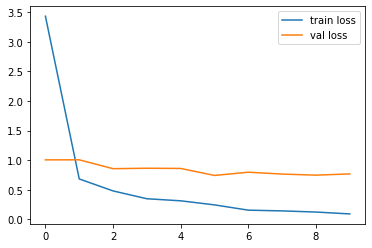

<Figure size 432x288 with 0 Axes>

In [42]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

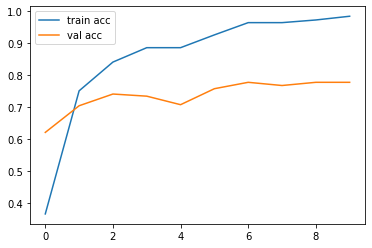

<Figure size 432x288 with 0 Axes>

In [43]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [44]:
# save model as a h5 file
model.save('model_vgg16.h5')

In [45]:
# Predicting the model 

y_pred = model.predict(test_set)

10/10 [==============================] - 3s 247ms/step


In [46]:
# printing y_predicted values 
y_pred

array([[1.02322735e-02, 1.98408397e-05, 9.87761855e-01, 1.80227275e-03,
        1.83844168e-04],
       [1.33558624e-05, 1.29127400e-07, 9.74349439e-01, 1.99162299e-04,
        2.54378896e-02],
       [9.45356429e-01, 5.28555736e-02, 1.21987341e-07, 1.78711931e-03,
        8.07692800e-07],
       ...,
       [7.59598892e-03, 5.06932940e-03, 6.88713133e-01, 6.76231633e-04,
        2.97945291e-01],
       [1.90252975e-01, 1.42804211e-05, 4.53510731e-01, 1.29078887e-03,
        3.54931176e-01],
       [1.61894504e-02, 4.35079710e-05, 9.57537532e-01, 2.16701943e-02,
        4.55925334e-03]], dtype=float32)

In [47]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [48]:
y_pred

array([2, 2, 0, 0, 1, 0, 2, 3, 0, 2, 2, 4, 0, 4, 2, 4, 4, 2, 4, 2, 1, 1,
       2, 0, 4, 1, 1, 0, 4, 2, 3, 2, 4, 4, 3, 2, 2, 4, 0, 3, 4, 1, 2, 0,
       2, 0, 1, 4, 4, 0, 0, 4, 2, 4, 3, 2, 4, 1, 0, 4, 2, 4, 4, 0, 1, 2,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 1, 4, 4, 2, 2, 4, 2, 1, 4, 4, 2, 3, 2,
       4, 3, 4, 3, 0, 4, 2, 4, 3, 3, 2, 4, 0, 2, 1, 3, 0, 2, 1, 0, 4, 3,
       0, 3, 3, 3, 1, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 4, 4, 1, 3, 1, 2, 1,
       3, 4, 1, 0, 3, 0, 3, 4, 2, 1, 3, 4, 2, 2, 0, 0, 2, 1, 3, 2, 2, 2,
       2, 0, 4, 2, 2, 2, 2, 4, 3, 3, 1, 3, 3, 4, 3, 3, 3, 0, 1, 3, 2, 1,
       4, 1, 3, 2, 4, 0, 1, 3, 0, 0, 0, 3, 0, 0, 2, 3, 1, 2, 2, 0, 1, 1,
       3, 0, 3, 2, 0, 4, 3, 4, 4, 0, 2, 0, 2, 2, 1, 0, 0, 1, 2, 0, 3, 0,
       0, 2, 2, 4, 1, 4, 1, 2, 3, 2, 0, 2, 0, 1, 4, 4, 4, 2, 4, 2, 0, 0,
       3, 2, 1, 1, 0, 4, 2, 1, 1, 0, 2, 0, 0, 1, 2, 3, 3, 4, 2, 4, 2, 4,
       0, 1, 1, 3, 4, 2, 3, 2, 1, 3, 1, 0, 3, 4, 2, 1, 3, 3, 1, 1, 4, 0,
       2, 2, 4, 1, 0, 0, 4, 2, 2, 2, 2, 2, 2, 2])

In [49]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [50]:
# Load the model which as saved earlier

from tensorflow.keras.models import load_model
model=load_model('model_vgg16.h5')

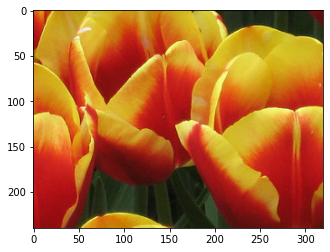

In [55]:
# Loading a test image and storing it in image
Z = plt.imread('tulip.jpg')
plt.imshow(Z)

In [56]:
# Loading a test image and storing it in image

img=image.load_img('tulip.jpg',target_size=(224,224))

x=image.img_to_array(img)
x.shape
x=x/255

In [53]:
from keras.applications.vgg16 import preprocess_input

In [57]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [58]:
# Predicting the image data and storing it in variable a

model.predict(img_data)
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 23ms/step


In [59]:
flower_name = ['dandelion',
 'sunflower',
 'tulip',
 'daisy',
 'rose']

In [60]:
flower_name[a[0]]

'dandelion'